# Факторный анализ с помощью частотного и Байесовского выводов

Факторный анализ - это статистический метод, применяемый для изучения взаимосвязей между значениями переменных с целью сокращения числа переменных и определения структуры взаимосвязей между переменными.  Главная идея ФА заключается в том, что имеющиеся зависимости между большим числом исходных наблюдаемых переменных определяются существованием гораздо меньшего числа латентных переменных, т.е. факторов.

In [ ]:
import arviz as az
import matplotlib
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
from numpy.random import default_rng

from google.colab import drive
drive.mount('/content/drive')
!pip install factor_analyzer
import pandas as pd
import factor_analyzer as fac
!pip install pymc3==3.11.0
import pymc3 as pm
import theano.tensor as tt

 Для проведения факторного анализа будем использовать [данные опроса клиентов о продуктах для 100 клиентов](https://www.kaggle.com/datasets/ipravin/hair-customer-survey-data-for-100-customers).

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Factor-Hair-Revised.csv', index_col=0)
print(data.shape)
data.head(5)

(100, 12)


,ProdQual,Ecom,TechSup,CompRes,Advertising,ProdLine,SalesFImage,ComPricing,WartyClaim,OrdBilling,DelSpeed,Satisfaction
ID,,,,,,,,,,,,
1,8.5,3.9,2.5,5.9,4.8,4.9,6.0,6.8,4.7,5.0,3.7,8.2
2,8.2,2.7,5.1,7.2,3.4,7.9,3.1,5.3,5.5,3.9,4.9,5.7
3,9.2,3.4,5.6,5.6,5.4,7.4,5.8,4.5,6.2,5.4,4.5,8.9
4,6.4,3.3,7.0,3.7,4.7,4.7,4.5,8.8,7.0,4.3,3.0,4.8
5,9.0,3.4,5.2,4.6,2.2,6.0,4.5,6.8,6.1,4.5,3.5,7.1


## Критерии пригодности данных для проведения факторного анализа

**Корреляционная матрица:**

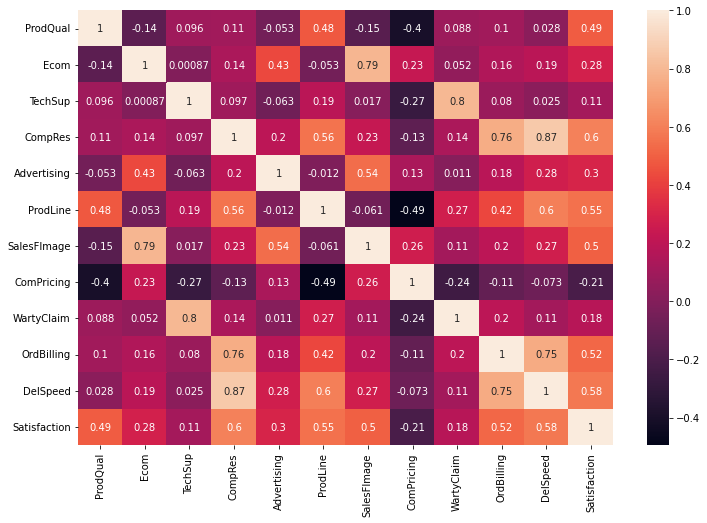

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True)

Почти все переменные сильно коррелируют между собой. Один из наиболее доступных критериев пригодности данных для проведения факторного анализа – величина взаимосвязи между переменными. Низкие коэффициенты корреляции (менее 0,3) свидетельствуют о нецелесообразности проведения ФА. При наличии большого количества низких коэффициентов корреляции факторный анализ становится проблематичным, так как исходные данные слишком разнородны.

**Тест Бартлетта** на сферичность проверяет, взаимокоррелируют ли вообще наблюдаемые переменные, используя наблюдаемую корреляционную матрицу против единичной матрицы. Если тест оказался статистически незначимым, факторный анализ выполнять не рекомендуется.

In [3]:
chi_square_value,p_value=fac.calculate_bartlett_sphericity(data)
print(chi_square_value, p_value)

769.64216640528 1.659709692234997e-120



Тест Бартлетта  дает p-значение равное 0. Тест статистически значим, что указывает на то, что наблюдаемая корреляционная матрица не является единичной матрицей.

**Тест Кайзера-Мейера-Олкина (КМО)** также измеряет пригодность данных для факторного анализа. Он определяет адекватность каждой наблюдаемой переменной и всей модели. KMO оценивает долю дисперсии среди всех наблюдаемых переменных. Значения от 0,5 до 1 говорят об адекватности факторного анализа, значения до 0,5 указывают на то, что факторный анализ неприменим к данным.

In [4]:
kmo_all,kmo_model=fac.calculate_kmo(data)
kmo_model

0.6624981842641786

Общий KMO для наших данных составляет 0,66.

### Определение количества факторов

 Для нахождения оптимального количества факторов выполним факторный анализ с 25-ю факторами.

In [5]:
fa = fac.FactorAnalyzer()
fa.fit(data, 25)
# Проверка собственныя значений
ev, v = fa.get_eigenvalues()
ev

array([4.04285997, 2.5529244 , 1.69222417, 1.21754639, 0.63596293,
       0.56853132, 0.40282774, 0.32448016, 0.23613948, 0.14422355,
       0.09913845, 0.08314143])

Только для 4-х факторов собственные значения больше единицы. Это означает, что следует выбрать только 4 фактора.

График каменистой осыпи Кеттела:

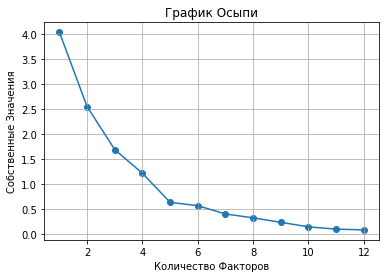

In [11]:
plt.scatter(range(1,data.shape[1]+1),ev)
plt.plot(range(1,data.shape[1]+1),ev)
plt.title('График Oсыпи')
plt.xlabel('Количество Факторов')
plt.ylabel('Собственные Значения')
plt.grid()
plt.show()

Исходя из графика, следует взять 4 фактора (больше 1).

### Факторный Анализ

In [6]:
# Создание объекта факторного анализа и выполнение факторного анализа
fa = fac.FactorAnalyzer(n_factors=4, rotation='varimax')
fa.fit(data)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [9]:
f_data = pd.concat([pd.Series(data.columns), pd.DataFrame(fa.loadings_)], axis=1)
f_data.columns = ['topic', '1', '2', '3', '4']
f_data

,topic,1,2,3,4
0,ProdQual,0.014180,-0.069173,0.008247,0.815078
1,Ecom,0.067974,0.756365,0.028584,-0.105826
2,TechSup,0.022548,-0.022923,0.865572,0.100146
3,CompRes,0.900127,0.135483,0.051626,0.128760
4,Advertising,0.161335,0.535101,-0.046789,-0.032993
5,ProdLine,0.554254,-0.098842,0.169145,0.582743
6,SalesFImage,0.106926,0.996462,0.055794,-0.071982
7,ComPricing,-0.112941,0.264890,-0.238296,-0.496986
8,WartyClaim,0.104725,0.053262,0.905298,0.098074
9,OrdBilling,0.763826,0.137873,0.083479,0.097978


Таблица выше показывает факторные нагрузки каждого фактора для каждой темы опроса. Все переменные имеют хотя бы один фактор с высокой факторной нагрузкой, кроме ComPricing, ProdLine, Advertising со средней факторной нагрузкой ≈ ± 0.5.

In [ ]:
# Сумма квадратов нагрузок (дисперся)
# Пропорциональня дисперсия
# Кумулятивная дисперсия
fa.get_factor_variance()

(array([2.92177469, 2.22614038, 1.6723292 , 1.66651776]),
 array([0.24348122, 0.1855117 , 0.13936077, 0.13887648]),
 array([0.24348122, 0.42899292, 0.56835369, 0.70723017]))

## Байесовский подход

Моделью факторного анализа является вероятностная матричная факторизация

$X_{(d,n)}|W_{(d,k)}, F_{(k,n)} \sim N(WF, \Psi)$

с диагональной матрицей $\Psi$. Нижние индексы обозначают размерность матриц. ( Реализация взята из [этого ноутбука](https://www.pymc.io/projects/examples/en/latest/case_studies/factor_analysis.html))

In [ ]:
k = 4
n = data.shape[0]
d = data.shape[1]
coords = {"latent_columns": np.arange(k), "rows": np.arange(n), "observed_columns": np.arange(d)}

with pm.Model(coords=coords) as PPCA:
    W = pm.Normal("W", dims=("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=tt.dot(W, F), sigma=psi, observed=data.T)

    trace = pm.sample(
        chains=4, tune=2000, return_inferencedata=True, random_seed=RANDOM_SEED
    )

/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


На данный момент уже есть несколько предупреждений относительно расходящихся выборок и неудачных проверок сходимости. 

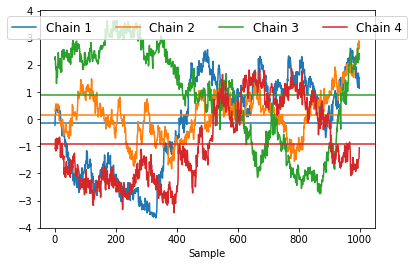

In [ ]:
for i in trace.posterior.chain.values:
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))
    plt.axhline(samples.mean(), color=f"C{i}")
plt.legend(ncol=4, loc="upper center", fontsize=12, frameon=True), plt.xlabel("Sample")

На графике следов сэмплирования выше показан путь, пройденный каждой цепочкой сэмплирования для одной записи в матрице, а также среднее значение в виде прямых линий.
Только две из четырех цепочек имеют одинаковые средние значения выборок, и мы также можем видеть, что между цепочками существует значительная автокорреляция. Некоторые из цепочек также могут иметь расхождения. Это говорит о том, что использование MCMC для этой модели неоптимально.

Это можно исправить, ограничив форму W следующим образом: + Нижний треугольный + Положительный с увеличивающейся диагональю

Функция expand_block_triangularк заполняет неквадратной матрицу и имитирует pm.expand_packed_triangular. Последняя работает только с квадратными матрицами.

In [ ]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="theano"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"theano", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "theano":
            return tt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = tt.zeros((d, k), dtype=float) if mtype == "theano" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out

Функция, создающая диагональную положительную матрицу с возрастающими элементами вдоль главной диагонали.

In [ ]:
def makeW(d, k, dim_names):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    z = pm.HalfNormal(
        "W_z", 1.0, shape=(k,)
    )  # trick: the cumulative sum of z will be positive increasing
    b = pm.HalfNormal("W_b", 1.0, shape=(n_od,))
    L = pm.Deterministic("W_L", expand_packed_block_triangular(d, k, b, tt.ones(k)))
    W = pm.Deterministic("W", tt.dot(L, tt.diag(tt.extra_ops.cumsum(z))), dims=dim_names)
    return W


Модель с обновленной матрицей.

ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


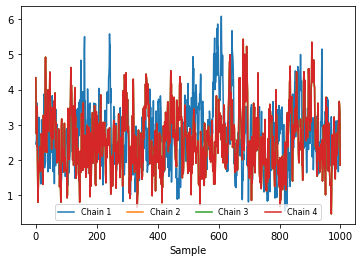

In [ ]:
with pm.Model(coords=coords) as PPCA_identified:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=tt.dot(W, F), sigma=psi, observed=data.T)
    trace = pm.sample(target_accept=0.9, tune=2000, return_inferencedata=True)

for i in range(4):
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1, method='nearest')
    plt.plot(samples, label="Chain {}".format(i + 1))

plt.legend(ncol=4, loc="lower center", fontsize=8), plt.xlabel("Sample");

В матрицах W и F теперь есть записи с идентичными апостериорными распределениями судя по сравнению цепочек сэмплирования.

Поскольку все параметры в F должны быть сэмплированы, сэмплирование может стать довольно дорогим для очень больших n. Кроме того, связь между наблюдаемой точкой данных и связанное с ним скрытое значение $X_i$ означает, что потоковый вывод с мини-пакетной обработкой не может быть выполнен.

Эта проблема масштабируемости может быть решена аналитически путем интеграции F
вне модели.

In [ ]:
with pm.Model(coords=coords) as PPCA_scaling:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    Y_mb = pm.Minibatch((data), 50)  # MvNormal parametrizes covariance of columns, so transpose Y
    psi = pm.HalfNormal("psi", 1.0)
    E = pm.Deterministic("cov", tt.dot(W, tt.transpose(W)) + psi * tt.diag(tt.ones(d)))
    X = pm.MvNormal("X", 0.0, cov=E, observed=Y_mb)
    trace_vi = pm.fit(n=50000, method="fullrank_advi", obj_n_mc=1).sample()

/usr/local/lib/python3.8/dist-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


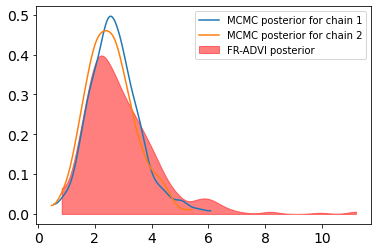

In [ ]:
for i in trace.posterior.chain.values:
    mcmc_samples = np.array(trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1))
    az.plot_kde(
        mcmc_samples,
        label="MCMC posterior for chain {}".format(i + 1),
        plot_kwargs={"color": f"C{i}"},
    )
az.plot_kde(
    trace_vi["W"][:, 3, 1],
    label="FR-ADVI posterior",
    plot_kwargs={"alpha": 0},
    fill_kwargs={"alpha": 0.5, "color": "red"},
)
plt.legend(loc="upper right");

 Все цепочки MCMC и оценка ADVI согласуются друг с другом.

###Апостериорная идентификация F

F был маргинализирован, чтобы облегчить подгонку модели.
Поэтому мы берем множество случайных переменных из стандартного нормального распределения, преобразуя их  следующим образом, чтобы представить апостериорное распределение F, которое является многомерным нормальным в рамках нашей модели.

$X|WF \sim N(WF, \Psi)$

$(W^TW)^{-1}W^T\Psi^{-1/2}X|W,F\sim N(F, (W^TW)^{-1})$

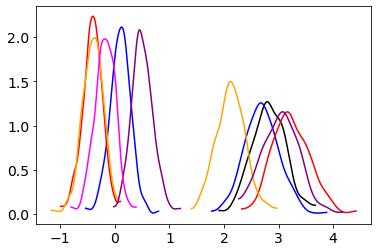

In [ ]:
n_samples = len(trace_vi)
F_sampled = np.zeros((n_samples, k, n))

for q in range(n_samples):
    Wq = trace_vi["W"][q, :, :]
    Pq = trace_vi["psi"][q]
    WWq = np.linalg.inv(np.dot(Wq.T, Wq))
    Fq_mu = np.dot(1 / np.sqrt(Pq) * np.dot(WWq, Wq.T), data.T)
    WWq_chol = np.linalg.cholesky(WWq)
    F_sampled[q, :, :] = Fq_mu + np.dot(WWq_chol, rng.standard_normal(size=(k, n)))

cols = ["black", "blue", "red", "orange", "purple", "magenta", "green", "yellow"]
for i in range(2):
    for j in range(5):
        az.plot_kde(F_sampled[:, i, j], plot_kwargs={"color": cols[(i + j) % len(cols)]});